In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

import sqlite3
import warnings
warnings.filterwarnings('ignore')

import datetime
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

import seaborn as sns; sns.set_theme(color_codes=True)
sns.set_context("paper")


In [2]:
conn = sqlite3.connect(r'/Users/rosaicelaroman/Desktop/portfolio_work/earthquake_modeling/Database/db/earthquake_db')
print("Connected to database...")

Connected to database...


In [3]:
model_df = pd.read_sql_query("SELECT * FROM earthquake_raw", conn)
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06T01:42:39.855Z,37.3840,-117.107500,1.10,1.30,ml,8.0,149.46,0.87500,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.10,0.290,4.0,automatic,nn,nn
1,2022-01-06T01:31:33.698Z,38.1810,-117.818000,7.30,1.40,ml,11.0,154.64,0.11900,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.00,0.460,5.0,automatic,nn,nn
2,2022-01-06T01:24:20.083Z,61.3407,-149.885200,30.00,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
3,2022-01-06T01:15:15.851Z,62.8703,-150.762500,111.30,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.80,NaN,NaN,automatic,ak,ak
4,2022-01-06T01:10:44.629Z,64.0145,-148.765700,1.90,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.60,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33889,2022-02-15T19:12:23.740Z,39.4215,-110.312333,-1.56,1.83,md,9.0,194.00,0.01022,0.1200,...,2022-02-15T19:51:17.520Z,"15 km SSE of Sunnyside, Utah",earthquake,0.63,0.36,0.324,7.0,reviewed,uu,uu
33890,2022-02-15T19:04:27.070Z,38.8250,-122.797167,2.68,0.41,md,25.0,44.00,0.01021,0.0300,...,2022-02-17T09:24:12.854Z,"6km NNW of The Geysers, CA",earthquake,0.18,0.28,0.129,3.0,reviewed,nc,nc
33891,2022-02-15T19:00:38.627Z,38.5375,-119.382100,0.00,1.40,ml,6.0,179.74,0.05500,0.1995,...,2022-02-16T02:37:07.010Z,"8 km ENE of Walker, California",earthquake,NaN,0.00,0.280,3.0,reviewed,nn,nn
33892,2022-02-15T18:52:46.384Z,55.3724,-159.286100,15.00,1.80,ml,NaN,NaN,NaN,0.5500,...,2022-03-05T17:45:05.111Z,"60 km SSE of Ivanof Bay, Alaska",earthquake,NaN,0.40,NaN,NaN,reviewed,ak,ak


In [4]:
model_df['time'] = pd.to_datetime(model_df['time'])
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06 01:42:39.855000+00:00,37.3840,-117.107500,1.10,1.30,ml,8.0,149.46,0.87500,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.10,0.290,4.0,automatic,nn,nn
1,2022-01-06 01:31:33.698000+00:00,38.1810,-117.818000,7.30,1.40,ml,11.0,154.64,0.11900,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.00,0.460,5.0,automatic,nn,nn
2,2022-01-06 01:24:20.083000+00:00,61.3407,-149.885200,30.00,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
3,2022-01-06 01:15:15.851000+00:00,62.8703,-150.762500,111.30,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.80,NaN,NaN,automatic,ak,ak
4,2022-01-06 01:10:44.629000+00:00,64.0145,-148.765700,1.90,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.60,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33889,2022-02-15 19:12:23.740000+00:00,39.4215,-110.312333,-1.56,1.83,md,9.0,194.00,0.01022,0.1200,...,2022-02-15T19:51:17.520Z,"15 km SSE of Sunnyside, Utah",earthquake,0.63,0.36,0.324,7.0,reviewed,uu,uu
33890,2022-02-15 19:04:27.070000+00:00,38.8250,-122.797167,2.68,0.41,md,25.0,44.00,0.01021,0.0300,...,2022-02-17T09:24:12.854Z,"6km NNW of The Geysers, CA",earthquake,0.18,0.28,0.129,3.0,reviewed,nc,nc
33891,2022-02-15 19:00:38.627000+00:00,38.5375,-119.382100,0.00,1.40,ml,6.0,179.74,0.05500,0.1995,...,2022-02-16T02:37:07.010Z,"8 km ENE of Walker, California",earthquake,NaN,0.00,0.280,3.0,reviewed,nn,nn
33892,2022-02-15 18:52:46.384000+00:00,55.3724,-159.286100,15.00,1.80,ml,NaN,NaN,NaN,0.5500,...,2022-03-05T17:45:05.111Z,"60 km SSE of Ivanof Bay, Alaska",earthquake,NaN,0.40,NaN,NaN,reviewed,ak,ak


In [5]:
#adding column of converted time to datetime
model_df['Unix Time'] = pd.to_datetime(model_df['time']).astype(int)/10**9
model_df.head(5)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,Unix Time
0,2022-01-06 01:42:39.855000+00:00,37.3840,-117.1075,1.1,1.3,ml,8.0,149.46,0.875,0.2175,...,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.1,0.29,4.0,automatic,nn,nn,1.641433e+09
1,2022-01-06 01:31:33.698000+00:00,38.1810,-117.8180,7.3,1.4,ml,11.0,154.64,0.119,0.1017,...,"34 km SE of Mina, Nevada",earthquake,NaN,2.0,0.46,5.0,automatic,nn,nn,1.641433e+09
2,2022-01-06 01:24:20.083000+00:00,61.3407,-149.8852,30.0,1.5,ml,NaN,NaN,NaN,0.7500,...,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.2,NaN,NaN,automatic,ak,ak,1.641432e+09
3,2022-01-06 01:15:15.851000+00:00,62.8703,-150.7625,111.3,2.1,ml,NaN,NaN,NaN,0.3200,...,"41 km N of Petersville, Alaska",earthquake,NaN,0.8,NaN,NaN,automatic,ak,ak,1.641432e+09
4,2022-01-06 01:10:44.629000+00:00,64.0145,-148.7657,1.9,1.5,ml,NaN,NaN,NaN,0.7200,...,"17 km E of Ferry, Alaska",earthquake,NaN,0.6,NaN,NaN,automatic,ak,ak,1.641431e+09


In [6]:
#drop columns not needed
cleaned_df = model_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_df

,latitude,longitude,depth,mag,Unix Time
0,37.3840,-117.107500,1.10,1.30,1.641433e+09
1,38.1810,-117.818000,7.30,1.40,1.641433e+09
2,61.3407,-149.885200,30.00,1.50,1.641432e+09
3,62.8703,-150.762500,111.30,2.10,1.641432e+09
4,64.0145,-148.765700,1.90,1.50,1.641431e+09
...,...,...,...,...,...
33889,39.4215,-110.312333,-1.56,1.83,1.644952e+09
33890,38.8250,-122.797167,2.68,0.41,1.644952e+09
33891,38.5375,-119.382100,0.00,1.40,1.644952e+09
33892,55.3724,-159.286100,15.00,1.80,1.644951e+09


In [7]:
cleaned_df.isnull().sum()

latitude     0
longitude    0
depth        0
mag          6
Unix Time    0
dtype: int64

In [8]:
cleaned_df_dropped = cleaned_df.dropna()

In [9]:
cleaned_df_dropped = cleaned_df_dropped.rename(columns={'latitude':'label'})
cleaned_df_dropped

,label,longitude,depth,mag,Unix Time
0,37.3840,-117.107500,1.10,1.30,1.641433e+09
1,38.1810,-117.818000,7.30,1.40,1.641433e+09
2,61.3407,-149.885200,30.00,1.50,1.641432e+09
3,62.8703,-150.762500,111.30,2.10,1.641432e+09
4,64.0145,-148.765700,1.90,1.50,1.641431e+09
...,...,...,...,...,...
33889,39.4215,-110.312333,-1.56,1.83,1.644952e+09
33890,38.8250,-122.797167,2.68,0.41,1.644952e+09
33891,38.5375,-119.382100,0.00,1.40,1.644952e+09
33892,55.3724,-159.286100,15.00,1.80,1.644951e+09


In [10]:
#establish features to be used in model. X will use: latitude, longitude, depth and unix time. Y will be magnitude
X = cleaned_df_dropped.drop(['label'], axis = 1)
X = np.asarray(X)

y = cleaned_df_dropped[['label']]
y= np.asarray(y)

In [11]:
#scale and transform the data
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [13]:
#following example: https://towardsdatascience.com/3-ways-to-create-a-machine-learning-model-with-keras-and-tensorflow-2-0-de09323af4d3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model


inputs = Input(shape=(4,))

input_layer = (inputs)
hidden_layer1 = Dense(10, activation='relu')(input_layer)
hidden_layer2 = Dense(5, activation='relu')(hidden_layer1)
hidden_layer3 = Dense(5, activation='relu')(hidden_layer2)
output = Dense(1, activation='linear')(hidden_layer3)

model = Model(inputs=inputs, outputs=output)


# model = Sequential([
#     Dense(5, activation='relu', input_shape=(4,)),
#     Dense(10, activation='relu'),
#     Dense(3, activation='softmax')
# ])

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 10)                50        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


2022-03-30 10:42:37.906985: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
#from https://towardsdatascience.com/deep-learning-with-python-neural-networks-complete-tutorial-6b53c0b06af0
'''
Extract info for each layer in a keras model.
'''
def utils_nn_config(model):
    lst_layers = []
    if "Sequential" in str(model): #-> Sequential doesn't show the input layer
        layer = model.layers[0]
        lst_layers.append({"name":"input", "in":int(layer.input.shape[-1]), "neurons":0, 
                           "out":int(layer.input.shape[-1]), "activation":None,
                           "params":0, "bias":0})
    for layer in model.layers:
        try:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":layer.units, 
                         "out":int(layer.output.shape[-1]), "activation":layer.get_config()["activation"],
                         "params":layer.get_weights()[0], "bias":layer.get_weights()[1]}
        except:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":0, 
                         "out":int(layer.output.shape[-1]), "activation":None,
                         "params":0, "bias":0}
        lst_layers.append(dic_layer)
    return lst_layers



'''
Plot the structure of a keras neural network.
'''
def visualize_nn(model, description=False, figsize=(10,8)):
    ## get layers info
    lst_layers = utils_nn_config(model)
    layer_sizes = [layer["out"] for layer in lst_layers]
    
    ## fig setup
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set(title=model.name)
    ax.axis('off')
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9
    x_space = (right-left) / float(len(layer_sizes)-1)
    y_space = (top-bottom) / float(max(layer_sizes))
    p = 0.025
    
    ## nodes
    for i,n in enumerate(layer_sizes):
        top_on_layer = y_space*(n-1)/2.0 + (top+bottom)/2.0
        layer = lst_layers[i]
        color = "green" if i in [0, len(layer_sizes)-1] else "blue"
        color = "red" if (layer['neurons'] == 0) and (i > 0) else color
        
        ### add description
        if (description is True):
            d = i if i == 0 else i-0.5
            if layer['activation'] is None:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
            else:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
                plt.text(x=left+d*x_space, y=top-p, fontsize=10, color=color, s=layer['activation']+" (")
                plt.text(x=left+d*x_space, y=top-2*p, fontsize=10, color=color, s="Σ"+str(layer['in'])+"[X*w]+b")
                out = " Y"  if i == len(layer_sizes)-1 else " out"
                plt.text(x=left+d*x_space, y=top-3*p, fontsize=10, color=color, s=") = "+str(layer['neurons'])+out)
        
        ### circles
        for m in range(n):
            color = "limegreen" if color == "green" else color
            circle = plt.Circle(xy=(left+i*x_space, top_on_layer-m*y_space-4*p), radius=y_space/4.0, color=color, ec='k', zorder=4)
            ax.add_artist(circle)
            
            ### add text
            if i == 0:
                plt.text(x=left-4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$X_{'+str(m+1)+'}$')
            elif i == len(layer_sizes)-1:
                plt.text(x=right+4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$y_{'+str(m+1)+'}$')
            else:
                plt.text(x=left+i*x_space+p, y=top_on_layer-m*y_space+(y_space/8.+0.01*y_space)-4*p, fontsize=10, s=r'$H_{'+str(m+1)+'}$')
    
    ## links
    for i, (n_a, n_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer = lst_layers[i+1]
        color = "green" if i == len(layer_sizes)-2 else "blue"
        color = "red" if layer['neurons'] == 0 else color
        layer_top_a = y_space*(n_a-1)/2. + (top+bottom)/2. -4*p
        layer_top_b = y_space*(n_b-1)/2. + (top+bottom)/2. -4*p
        for m in range(n_a):
            for o in range(n_b):
                line = plt.Line2D([i*x_space+left, (i+1)*x_space+left], 
                                  [layer_top_a-m*y_space, layer_top_b-o*y_space], 
                                  c=color, alpha=0.5)
                if layer['activation'] is None:
                    if o == m:
                        ax.add_artist(line)
                else:
                    ax.add_artist(line)
    plt.show()

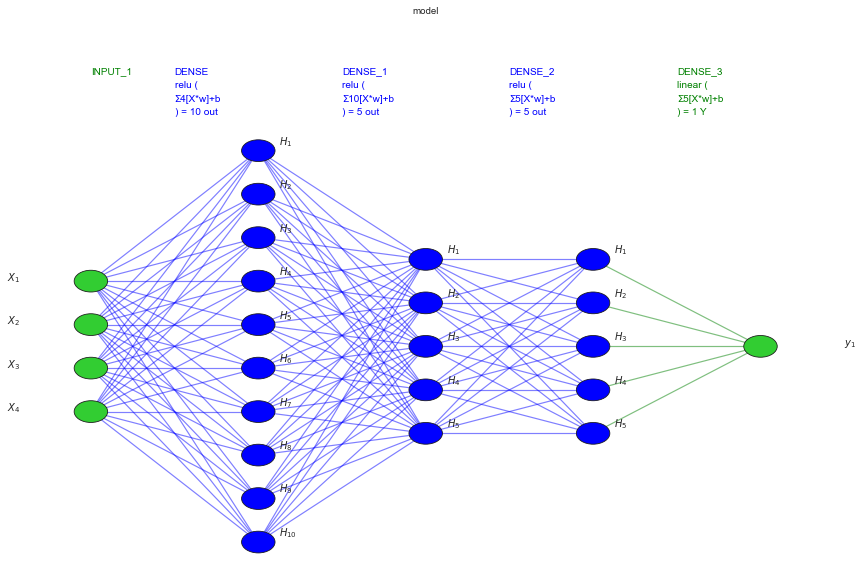

In [15]:
visualize_nn(model, description=True, figsize=(15,10))

In [16]:
model.compile(
    optimizer='Adagrad',
    loss="mean_squared_error",
    metrics = ['mae']
)

In [17]:
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=400,
    validation_split=0.2,
    verbose=2
)

2022-03-30 10:42:38.809506: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/400
568/568 - 1s - loss: 0.8455 - mae: 0.6511 - val_loss: 0.7893 - val_mae: 0.6206
Epoch 2/400
568/568 - 0s - loss: 0.7991 - mae: 0.6212 - val_loss: 0.7630 - val_mae: 0.6065
Epoch 3/400
568/568 - 0s - loss: 0.7769 - mae: 0.6106 - val_loss: 0.7461 - val_mae: 0.5999
Epoch 4/400
568/568 - 0s - loss: 0.7612 - mae: 0.6056 - val_loss: 0.7340 - val_mae: 0.5975
Epoch 5/400
568/568 - 0s - loss: 0.7493 - mae: 0.6032 - val_loss: 0.7248 - val_mae: 0.5965
Epoch 6/400
568/568 - 0s - loss: 0.7401 - mae: 0.6018 - val_loss: 0.7175 - val_mae: 0.5964
Epoch 7/400
568/568 - 0s - loss: 0.7327 - mae: 0.6017 - val_loss: 0.7117 - val_mae: 0.5967
Epoch 8/400
568/568 - 0s - loss: 0.7267 - mae: 0.6014 - val_loss: 0.7069 - val_mae: 0.5971
Epoch 9/400
568/568 - 0s - loss: 0.7217 - mae: 0.6017 - val_loss: 0.7029 - val_mae: 0.5976
Epoch 10/400
568/568 - 0s - loss: 0.7174 - mae: 0.6019 - val_loss: 0.6995 - val_mae: 0.5980
Epoch 11/400
568/568 - 0s - loss: 0.7136 - mae: 0.6020 - val_loss: 0.6964 - val_mae: 0.59

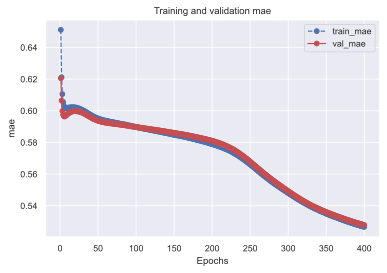

In [18]:
#following example: https://towardsdatascience.com/3-ways-to-create-a-machine-learning-model-with-keras-and-tensorflow-2-0-de09323af4d3
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()


# val_metrics = history.history['val_'+metric]
# print(val_metrics)
plot_metric(history, 'mae')

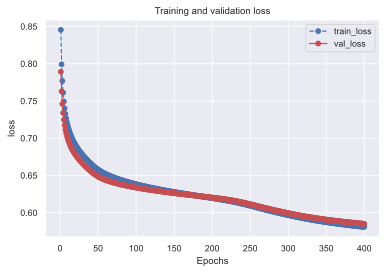

In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()


# val_metrics = history.history['val_'+metric]
# print(val_metrics)
plot_metric(history, 'loss')

In [20]:
# def get_uncompiled_model():
#     inputs = keras.Input(shape=(784,), name="digits")
#     x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
#     x = layers.Dense(64, activation="relu", name="dense_2")(x)
#     outputs = layers.Dense(10, activation="softmax", name="predictions")(x)
#     model = keras.Model(inputs=inputs, outputs=outputs)
#     return model


# def get_compiled_model():
#     model = get_uncompiled_model()
#     model.compile(
#         optimizer="rmsprop",
#         loss="sparse_categorical_crossentropy",
#         metrics=["sparse_categorical_accuracy"],
#     )
#     return model

In [21]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test mae:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(X_test[:])
print("predictions shape:", predictions.shape)

Evaluate on test data
350/350 [==============================] - 0s 436us/step - loss: 0.5909 - mae: 0.5311
test loss, test mae: [0.5909221768379211, 0.5310757756233215]
Generate predictions for 3 samples
predictions shape: (11184, 1)


In [22]:
predictions_t=sc_y.inverse_transform(predictions)
print(predictions_t)

[[41.6924  ]
 [-9.378996]
 [40.04484 ]
 ...
 [46.03074 ]
 [39.85747 ]
 [41.662056]]


In [23]:
actual_lat=sc_y.inverse_transform(y_test)
df_pred = pd.DataFrame(actual_lat, columns=['Actual'])
df_pred['Predicted'] = predictions_t
df_pred

,Actual,Predicted
0,36.562500,41.692402
1,-9.963400,-9.378996
2,40.160500,40.044842
3,38.839832,39.199780
4,-23.717300,-3.745982
...,...,...
11179,59.876800,46.652039
11180,36.842667,37.612766
11181,19.480000,46.030739
11182,38.190800,39.857471


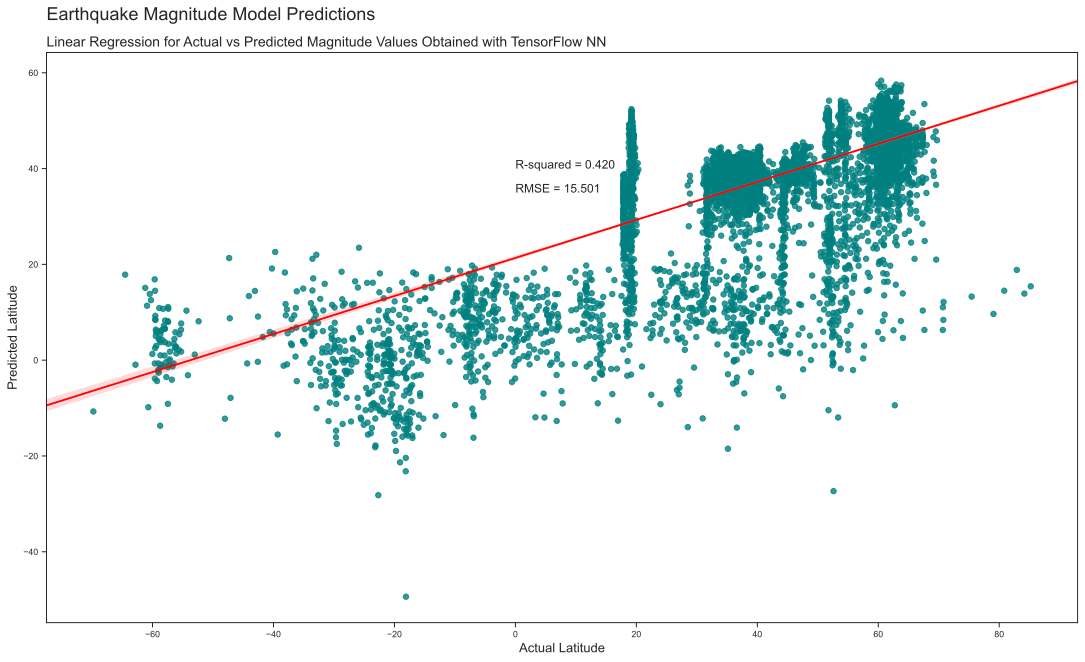

In [35]:
x = np.array(df_pred['Actual'])
y = np.array(df_pred['Predicted'])
test_mse = mean_squared_error(actual_lat,predictions_t)
rmse = sqrt(test_mse)

sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'teal'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Latitude', fontsize=13)
plt.xlabel('Actual Latitude',  fontsize=13)
# Bigger title
plt.suptitle('Earthquake Magnitude Model Predictions', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Magnitude Values Obtained with TensorFlow NN', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(x, y)), (0, 40),  fontsize=12)
plt.annotate("RMSE = {:.3f}".format(rmse), (0,35), fontsize=12)

# fig.savefig('extratrees_mag_linear_sns.png', dpi=600)
plt.show()

In [25]:
page_url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_day.csv"

test_df = pd.read_csv(page_url)
test_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-03-30T17:39:47.620Z,33.537500,-116.456833,13.510000,0.47,ml,18.0,51.00,0.029560,0.2700,...,2022-03-30T17:43:18.338Z,"20km SW of La Quinta, CA",earthquake,0.56,1.11,0.202000,8.0,automatic,ci,ci
1,2022-03-30T17:26:01.880Z,33.416668,-116.360169,13.380000,1.45,ml,44.0,107.00,0.068720,0.2000,...,2022-03-30T17:37:15.570Z,"18km N of Borrego Springs, CA",earthquake,0.31,0.63,0.174000,13.0,automatic,ci,ci
2,2022-03-30T17:21:59.120Z,19.215666,-155.408005,33.290001,2.02,md,36.0,152.00,NaN,0.1100,...,2022-03-30T17:25:02.340Z,"7 km E of Pāhala, Hawaii",earthquake,0.59,0.71,0.450000,5.0,automatic,hv,hv
3,2022-03-30T17:15:55.114Z,38.144800,-117.977700,6.600000,1.90,ml,14.0,133.67,0.015000,0.2336,...,2022-03-30T17:19:56.930Z,"29 km SSE of Mina, Nevada",earthquake,NaN,0.30,0.750000,9.0,automatic,nn,nn
4,2022-03-30T17:15:39.800Z,33.461667,-116.573833,9.330000,0.55,ml,18.0,73.00,0.040590,0.1800,...,2022-03-30T17:19:22.014Z,"14km SE of Anza, CA",earthquake,0.53,0.81,0.156000,12.0,automatic,ci,ci
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,2022-03-29T17:48:04.110Z,38.812500,-122.792168,2.880000,0.89,md,28.0,41.00,0.005146,0.0200,...,2022-03-29T17:49:40.309Z,"5km NW of The Geysers, CA",earthquake,0.20,0.41,0.040000,5.0,automatic,nc,nc
250,2022-03-29T17:47:14.830Z,35.881000,-117.697667,4.170000,0.91,ml,16.0,48.00,0.077010,0.0800,...,2022-03-29T19:00:05.336Z,"20km ESE of Little Lake, CA",earthquake,0.15,0.41,0.190000,7.0,reviewed,ci,ci
251,2022-03-29T17:47:10.210Z,36.959200,-116.109800,6.900000,0.50,ml,9.0,90.29,0.051000,0.1250,...,2022-03-30T02:38:36.083Z,California-Nevada border region,earthquake,NaN,2.00,0.230000,8.0,reviewed,nn,nn
252,2022-03-29T17:44:33.130Z,52.329000,-174.165333,-2.240000,0.09,ml,5.0,232.00,NaN,0.2700,...,2022-03-30T04:21:22.510Z,"14 km N of Atka, Alaska",earthquake,1.34,2.96,0.450031,5.0,reviewed,av,av


In [26]:
test_df['Unix Time'] = pd.to_datetime(test_df['time']).astype(int)/10**9

In [27]:
cleaned_test_df = test_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_test_df

,latitude,longitude,depth,mag,Unix Time
0,33.537500,-116.456833,13.510000,0.47,1.648662e+09
1,33.416668,-116.360169,13.380000,1.45,1.648661e+09
2,19.215666,-155.408005,33.290001,2.02,1.648661e+09
3,38.144800,-117.977700,6.600000,1.90,1.648661e+09
4,33.461667,-116.573833,9.330000,0.55,1.648661e+09
...,...,...,...,...,...
249,38.812500,-122.792168,2.880000,0.89,1.648576e+09
250,35.881000,-117.697667,4.170000,0.91,1.648576e+09
251,36.959200,-116.109800,6.900000,0.50,1.648576e+09
252,52.329000,-174.165333,-2.240000,0.09,1.648576e+09


In [28]:
cleaned_test_df.isnull().sum()

latitude     0
longitude    0
depth        0
mag          0
Unix Time    0
dtype: int64

In [29]:
#establish features to be used in model. X will use: latitude, longitude, depth and unix time. Y will be magnitude
X = cleaned_test_df.drop(['latitude'], axis = 1)
X = np.asarray(X)

y = cleaned_test_df[['latitude']]
y= np.asarray(y)

In [30]:
#scale and transform the data
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)

In [31]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X, y)
print("test loss, test mae:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for all samples")
predictions = model.predict(X[:])
print("predictions shape:", predictions.shape)

Evaluate on test data
8/8 [==============================] - 0s 660us/step - loss: 0.5823 - mae: 0.5631
test loss, test mae: [0.5822968482971191, 0.5631470084190369]
Generate predictions for all samples
predictions shape: (254, 1)


In [32]:
predictions_t2=sc_y.inverse_transform(predictions)
print(predictions_t2)

[[ 41.320923  ]
 [ 35.340786  ]
 [ 34.898266  ]
 [ 32.442696  ]
 [ 40.06878   ]
 [ 37.65796   ]
 [ 39.06436   ]
 [ 37.748455  ]
 [ 41.14124   ]
 [ 32.803852  ]
 [ -1.7886684 ]
 [ -8.503272  ]
 [ 45.266838  ]
 [ 41.920124  ]
 [ 45.122845  ]
 [ 30.765152  ]
 [ 30.545877  ]
 [ 45.36296   ]
 [ 39.29019   ]
 [ 34.15728   ]
 [ 44.67843   ]
 [ 34.66271   ]
 [ 21.73332   ]
 [ 37.990498  ]
 [ 33.89185   ]
 [ 38.347176  ]
 [ 33.90378   ]
 [ 38.399624  ]
 [ 38.38125   ]
 [ 38.271244  ]
 [ 26.115446  ]
 [ 37.905003  ]
 [ 36.810154  ]
 [ 37.902924  ]
 [ 32.496872  ]
 [ 44.37691   ]
 [ 20.17629   ]
 [ 44.50572   ]
 [ 37.069016  ]
 [ 39.408287  ]
 [ 35.656258  ]
 [ 38.046227  ]
 [ 37.140377  ]
 [ 25.132828  ]
 [ 27.427248  ]
 [ 35.964947  ]
 [  6.6991286 ]
 [ 41.112656  ]
 [ 37.86037   ]
 [ 36.79232   ]
 [ 37.51855   ]
 [ 10.388778  ]
 [ 37.03322   ]
 [ 42.985176  ]
 [ 12.887107  ]
 [ 35.07292   ]
 [ 44.877068  ]
 [ 36.5066    ]
 [ 37.64364   ]
 [ 30.299215  ]
 [ 26.675047  ]
 [ 27.59354   ]
 [ 39.58

In [33]:
actual_lat2=sc_y.inverse_transform(y)
dftest_pred = pd.DataFrame(actual_lat2, columns=['Actual'])
dftest_pred['Predicted'] = predictions_t2
dftest_pred

,Actual,Predicted
0,33.537500,41.320923
1,33.416668,35.340786
2,19.215666,34.898266
3,38.144800,32.442696
4,33.461667,40.068779
...,...,...
249,38.812500,37.414764
250,35.881000,37.126476
251,36.959200,37.351181
252,52.329000,46.164165


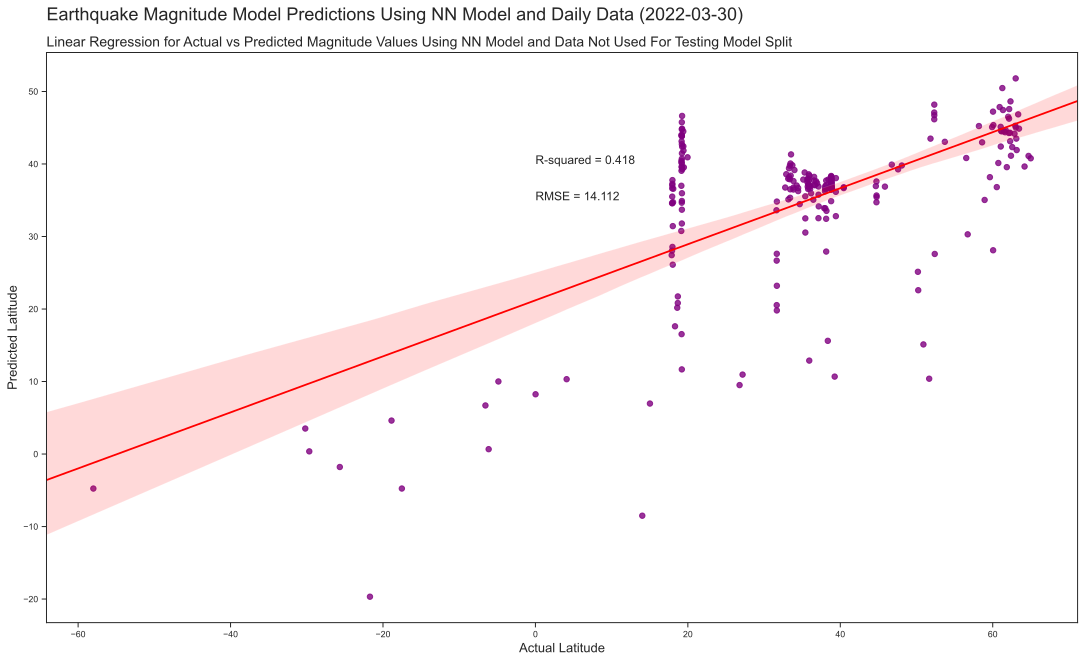

In [36]:
from datetime import date
today = date.today()

x = np.array(dftest_pred['Actual'])
y = np.array(dftest_pred["Predicted"])
test_mse = mean_squared_error(actual_lat2,predictions_t2)
rmse = sqrt(test_mse)

sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'purple'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Latitude', fontsize=13)
plt.xlabel('Actual Latitude',  fontsize=13)
# Bigger title
plt.suptitle(f'Earthquake Magnitude Model Predictions Using NN Model and Daily Data ({today})', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Magnitude Values Using NN Model and Data Not Used For Testing Model Split', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(x, y)), (0, 40),  fontsize=12)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 35), fontsize=12)

# fig.savefig('extratrees_mag_linear_sns.png', dpi=600)
plt.show()